In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm
from time import time, sleep

from pycbc.types.timeseries import TimeSeries

import warnings
warnings.filterwarnings("ignore")

from tempgen import *



# GR units
pc=3.08*10**(16)
G=6.67*10**(-11)
c=3*10**8
Ms=1.98*10**(30)

## Get Templates with Duration < 1000 s

In [2]:
df = pd.read_csv('lin.csv')
df.drop(['Unnamed: 0', 'keep'], axis=1, inplace=True)

amps = []

for i in range(df.shape[0]):
    j = df.iloc[i]
    
    m, ri, Qi = j['M']/2, j['ri'], j['Qi']
    
    
    amp = get_amp(m, m, ri, Qi, Dl=0)
    amps.append(abs(amp))
    
df['amps'] = amps
df

,Qi,ri,M,amps
0,-8.0,1.0,1,2.451429e-14
1,-8.0,2.0,1,6.128572e-15
2,-8.0,3.0,1,2.723809e-15
3,-8.0,4.0,1,1.532142e-15
4,-8.0,5.0,1,9.805706e-16
...,...,...,...,...
145,-5.0,2.0,50,7.660177e-16
146,-5.0,3.0,50,3.404223e-16
147,-5.0,4.0,50,1.914640e-16
148,-5.0,5.0,50,1.225175e-16


 99%|██████████████████████████████████████████▍| 79/80 [00:01<00:00, 54.70it/s]


Text(0.5, 1.0, 'Templates with 33% power')

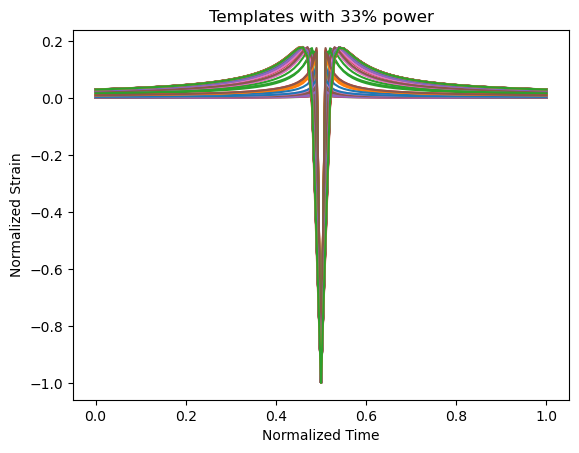

In [3]:
durs = []
valid = []

for i, z in zip(range(df.shape[0]), tqdm(range(df.shape[0]))):
    j = df.iloc[i]
    
    m, ri, Qi, Amp = j['M']/2, j['ri'], j['Qi'], j['amps']
    
    m1, m2, ri, Qi, vi, M, Mu, GM, L, phi0, rmin, p, ecc = get_orbit(m, m, ri, Qi)
    
    hp = get_wave(j['M']/2, j['M']/2, j['ri'], j['Qi'], duration = 1000, dt = 1, acc=40, incor=True, Dl=0)[0]
    
    dur = False
    if hp[0] > 0:
        
        
        if hp[0] < Amp/33:
            
            if hp[0] == hp[1] and hp[1] == hp[2]:
                print(i, i)
            if hp[0] < hp[1] and hp[1] < hp[2]:
                dur = True
    durs.append(dur)
    
df['durs'] = durs
df2 = df[df['durs']].copy()
df2 = df2.reset_index()


durs = []
valid = []

for i, z in zip(range(df2.shape[0]), tqdm(range(df2.shape[0]))):
    j = df2.iloc[i]
    
    m, ri, Qi, Amp = j['M']/2, j['ri'], j['Qi'], j['amps']
    
    m1, m2, ri, Qi, vi, M, Mu, GM, L, phi0, rmin, p, ecc = get_orbit(m, m, ri, Qi)
    
    start = 0
    stop = phi0
    bounds = [1/35, 1/33]
    
    T = time()
    while True:
    
        mid = (start + stop)/2
    
        amp = (H_pols(mid, phi0, Mu, GM, pc, L, ecc, rmin)/Amp)[0]
        
        if amp >=  bounds[0] and amp <=  bounds[1]:
            break
        elif amp < bounds[0] :
            start = mid
        elif amp > bounds[1]:
            stop = mid
    
            
    phi = phi0-mid
    ecc2 = np.sqrt(ecc**2-1)
    t = 2*p**2/L/(ecc2**3) * (np.arctanh( (ecc-1)/ecc2 * np.tan(phi/2)) - ecc*ecc2*np.sin(phi)/(1+ecc*np.cos(phi))/2)
    t *= -2
    
    hp = get_wave(j['M']/2, j['M']/2, j['ri'], j['Qi'], duration = t, dt = t/100, acc=30, incor=True)[0]

    if hp[-1] == max(hp) or hp[0] == max(hp):
        print(i, 'second')

        start = 0
        stop = (2*np.pi + phi0)/5
        bounds = [1/35, 1/33]
        while True:
    
            mid = (start + stop)/2
    
            amp = abs((H_pols(mid, phi0, Mu, GM, pc, L, ecc, rmin)/Amp)[0])
            
        
            if amp >=  bounds[0] and amp <=  bounds[1]:
                break
            elif amp < bounds[0] :
                start = mid
            elif amp > bounds[1]:
                stop = mid


        phi = phi0-mid
        ecc2 = np.sqrt(ecc**2-1)
        t = 2*p**2/L/(ecc2**3) * (np.arctanh( (ecc-1)/ecc2 * np.tan(phi/2)) - ecc*ecc2*np.sin(phi)/(1+ecc*np.cos(phi))/2)
        t *= -2
        
        hp = get_wave(j['M']/2, j['M']/2, j['ri'], j['Qi'], duration = t, dt = t/100, acc=40, incor=True)[0]
        
    if hp[-1] == max(hp) or hp[0] == max(hp):
        valid.append(False)
    else:
        valid.append(True)
    
    durs.append(t)

df2['dur'] = durs


for i, z in zip(range(df2.shape[0]), tqdm(range(df2.shape[0]))):
    j = df2.iloc[i]
    
    
    hp = get_wave(j['M']/2, j['M']/2, j['ri'], j['Qi'], duration = int(j['dur'])+1, dt = (int(j['dur'])+1)/100, acc=40, incor=True, Dl=0)[0]
    
    
    hp /= j['amps']
    
    
    x = np.linspace(0, 1, len(hp))
    
    
    plt.plot(x, hp, c = 'C' + str( np.mod(i, 7)))
    
plt.xlabel('Normalized Time')
plt.ylabel('Normalized Strain')
plt.title('Templates with 33% power')

In [7]:
df2.drop(['index', 'durs'], axis=1, inplace=True)
df2.to_csv('prop_durs.csv', index=False)


## Showing the effect of low accuracy in previous templates

In [2]:
import pycbc
from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter.resample import resample_to_delta_t
from pycbc.events import ThresholdCluster
from pycbc.filter import matched_filter, resample_to_delta_t, highpass_fir
from pycbc.vetoes import power_chisq
from pycbc.filter.matchedfilter import sigma
from pycbc.events.ranking import newsnr

from tempgen import *
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import tukey

flow = 20
fhigh = 250

strain = TimeSeries(np.loadtxt('Gaussian_4096s_512Hz.txt'), delta_t=1/512)
strain = strain.highpass_fir(flow, 512).lowpass_fir(fhigh, 512)
strain.start_time=0

In [3]:
import math

df = pd.read_csv('prop_durs.csv')
df['dur'] = df['dur'].apply(math.ceil)
j = df[df['dur'] == df['dur'].max()]
j

,Qi,ri,M,amps,dur
59,-5.5,1.0,25,3.830331e-15,982


100%|███████████████████████████████▉| 251392/251393 [00:11<00:00, 21199.55it/s]


low


100%|████████████████████████████████▉| 251392/251393 [00:31<00:00, 7943.63it/s]


med


100%|████████████████████████████████▉| 251392/251393 [01:20<00:00, 3114.18it/s]


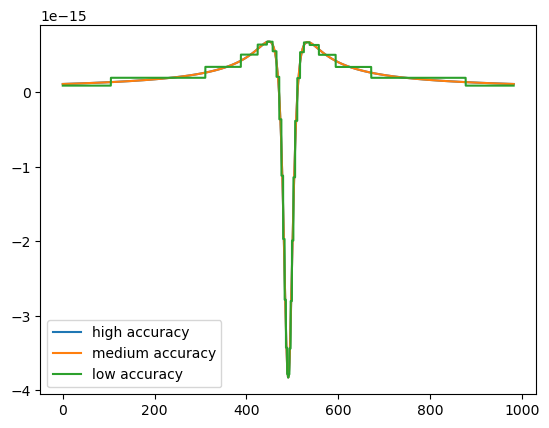

In [3]:
from scipy.signal import tukey

low, _ = get_wave(12.5, 12.5, 1, -5.5, duration = 982, dt = 1/512, acc=5, load=True)
print('low')
mid, _ = get_wave(12.5, 12.5, 1, -5.5, duration = 982, dt = 1/512, acc=15, load=True)
print('med')
high, _ = get_wave(12.5, 12.5, 1, -5.5, duration = 982, dt = 1/512, acc=40, load=True)


high.plot(label='high accuracy')
mid.plot(label='medium accuracy')
low.plot(label='low accuracy')
plt.legend()

low *= tukey(len(low), 0.25)
mid *= tukey(len(mid), 0.25)
high *= tukey(len(high), 0.25)

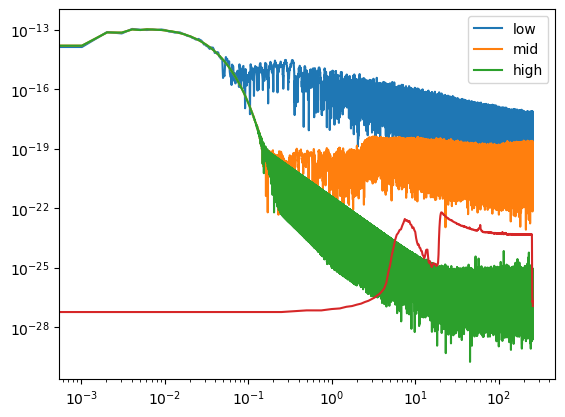

In [4]:
f_low = low.to_frequencyseries()
f_mid = mid.to_frequencyseries()
f_high = high.to_frequencyseries()

freq = f_low.sample_frequencies
PSD = strain.psd(4)

plt.plot(freq, abs(f_low), label='low')
plt.plot(freq, abs(f_mid), label='mid')
plt.plot(freq, abs(f_high), label='high')
plt.loglog(PSD.sample_frequencies, PSD**0.5)
plt.legend()

In [5]:
def Sigma(hp):
    
    if hp.duration < 8:
        hp.resize(len(Dur))
    
    PSD = interpolate(strain.psd(4), hp.delta_f)
    PSD = inverse_spectrum_truncation(PSD, int(4 * strain.sample_rate), trunc_method='hann')
    Dh = sigma(hp, PSD, low_frequency_cutoff=30, high_frequency_cutoff=250)/(8)
    return Dh

In [6]:
print('Sigma with low accuracy: ' + str(Sigma(low)))
print('Sigma with medium accuracy: ' + str(Sigma(mid)))
print('Sigma with high accuracy: ' + str(Sigma(high)))

Sigma with low accuracy: 2600166.43300836
Sigma with medium accuracy: 47224.837806228454
Sigma with high accuracy: 0.0227900122892671


## Finding optimal accuracy

This problem arises as the strain becomes a step function with lower accuracy. Once the accuracy is high enough, the steps vanish, so i just have to make sure that there are no steps

In [12]:
rats = []
dt = 1/512
times = np.linspace(-500, -500 + dt*30)
times

for i, z in zip(range(df.shape[0]), tqdm(range(df.shape[0]))):
    j = df.iloc[i]    
    
    hp = get_wave(j['M']/2, j['M']/2, j['ri'], j['Qi'], duration = int(j['dur'])+1, dt =1/512, acc=40, incor=True, Dl=0, times = times)[0][:len(times)]
    
    if hp[0] == hp[1] or hp[1] == hp[2] or hp[2] == hp[3] or hp[3] == hp[4]:
        print(i)
#plt.yscale('log')
    


 99%|█████████████████████████████████████████▍| 79/80 [00:00<00:00, 112.66it/s]
